In [22]:
# Önce fotoğrafı yüklüyorum ve renk işlemleri için RGB/HSV formatlarına çeviriyorum.
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread("leaf1.jpg")
assert img is not None, "leaf1.jpg bulunamadı. Dosyayı notebook ile aynı klasöre koy."

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

h, w = hsv.shape[:2]


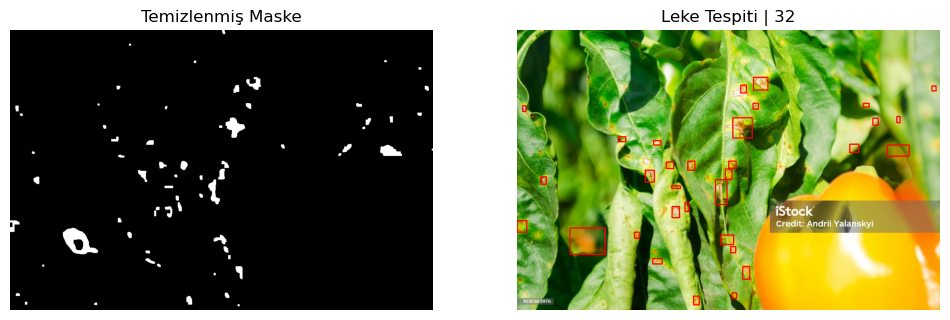

Toplam Leke: 32


In [23]:
# Maskeleme + Leke Tespiti (HSV + Morfoloji + Kontur)
# HSV’de renk eşikleyip gürültüyü temizliyorum, sonra konturlarla lekeleri bulup kutu çiziyorum.

# Sağ alt köşedeki biber alanını analiz dışı bırakmak için maske
remove_biber = np.zeros((h, w), np.uint8)
cv2.rectangle(remove_biber, (int(w*0.55), int(h*0.45)), (w, h), 255, -1)

# Kahverengi/Sarı leke aralığı (HSV)
lower = np.array([12, 60, 50])
upper = np.array([30, 255, 220])
mask_color = cv2.inRange(hsv, lower, upper)

# Biber olmayan bölgede maske uygula
mask_color = cv2.bitwise_and(mask_color, mask_color, mask=~remove_biber)

# Maske temizliği (gürültü azaltma)
kernel = np.ones((5, 5), np.uint8)
mask_clean = cv2.morphologyEx(mask_color, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN, kernel, iterations=1)

# Kontur tespiti + kutu çizme
contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

img_detect = img_rgb.copy()
spots = []

for cnt in contours:
    area = cv2.contourArea(cnt)
    if area < 80 or area > 5000:
        continue
    x, y, w_, h_ = cv2.boundingRect(cnt)
    spots.append((x, y, w_, h_))
    cv2.rectangle(img_detect, (x, y), (x + w_, y + h_), (255, 0, 0), 2)

# Görselleştirme
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Temizlenmiş Maske")
plt.imshow(mask_clean, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title(f"Leke Tespiti | {len(spots)}")
plt.imshow(img_detect)
plt.axis("off")

plt.show()

print("Toplam Leke:", len(spots))


In [24]:
# Bulduğum her lekeyi alanına göre hafif-orta-ciddi diye sınıflandırıyorum.

hafif = 0
orta = 0
ciddi = 0

for (x, y, w_, h_) in spots:
    alan = w_ * h_
    if alan < 200:
        hafif += 1
    elif alan < 800:
        orta += 1
    else:
        ciddi += 1

print("Hafif:", hafif, "| Orta:", orta, "| Ciddi:", ciddi)


Hafif: 10 | Orta: 17 | Ciddi: 5


In [25]:
#  Bitki Sağlık Skoru (0–100)
# Şiddetleri ağırlıklandırıp tek bir sağlık skoruna dönüştürüyorum.

puan = hafif*1 + orta*3 + ciddi*6
saglik_skoru = 100 - (puan / 200 * 100)
saglik_skoru = max(0, min(100, saglik_skoru))

print("Toplam Hasar Puanı:", puan)
print("Bitki Sağlık Skoru:", round(saglik_skoru, 2))


Toplam Hasar Puanı: 91
Bitki Sağlık Skoru: 54.5


In [26]:
# Rapor Tablosu (Pandas)
# Sonuçları tek tabloda toplayıp rapor formatına getiriyorum.

import pandas as pd

data = {
    "Özellik": [
        "Toplam Leke Sayısı",
        "Hafif Leke",
        "Orta Leke",
        "Ciddi Leke",
        "Toplam Hasar Puanı",
        "Bitki Sağlık Skoru"
    ],
    "Değer": [
        hafif + orta + ciddi,
        hafif,
        orta,
        ciddi,
        puan,
        f"%{round(saglik_skoru, 2)}"
    ]
}

rapor_df = pd.DataFrame(data)
rapor_df


,Özellik,Değer
0,Toplam Leke Sayısı,32
1,Hafif Leke,10
2,Orta Leke,17
3,Ciddi Leke,5
4,Toplam Hasar Puanı,91
5,Bitki Sağlık Skoru,%54.5


In [27]:
# Skora göre otomatik bir cümle ile özetliyorum.

if saglik_skoru > 80:
    durum = "Bitki sağlıklı görünüyor."
elif saglik_skoru > 60:
    durum = "Hafif hastalık belirtileri mevcut."
elif saglik_skoru > 40:
    durum = "Orta seviyede hastalık mevcut, bakım önerilir."
else:
    durum = "Ciddi hastalık var, acil müdahale gerekebilir."

print("Genel Durum:", durum)


Genel Durum: Orta seviyede hastalık mevcut, bakım önerilir.


In [28]:
# Kural tabanlı bir hastalık tahmini oluşturdum
# Bu kısım ML değil; renk oranları ve şiddet dağılımıyla basit bir tahmin yapıyorum.

img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

analiz_alani = np.sum((~remove_biber) > 0)

kahverengi_maske = cv2.inRange(img_hsv, (5, 50, 20), (20, 255, 200))
kahverengi_maske = cv2.bitwise_and(kahverengi_maske, kahverengi_maske, mask=~remove_biber)
kahverengi_oran = np.sum(kahverengi_maske > 0) / analiz_alani * 100

sari_maske = cv2.inRange(img_hsv, (20, 50, 80), (35, 255, 255))
sari_maske = cv2.bitwise_and(sari_maske, sari_maske, mask=~remove_biber)
sari_oran = np.sum(sari_maske > 0) / analiz_alani * 100

if ciddi > 5 or kahverengi_oran > 10:
    hastalik = "Fungal Yaprak Lekesi (Leaf Spot)"
elif orta > 10 or kahverengi_oran > 5:
    hastalik = "Başlangıç Seviye Fungal Enfeksiyon"
elif sari_oran > 15:
    hastalik = "Azot Eksikliği veya Güneş Yanığı"
elif hafif > 10:
    hastalik = "Hafif Yaprak Lekesi"
else:
    hastalik = "Belirgin bir hastalık belirtisi yok."

print("Kahverengi oran (%):", round(kahverengi_oran, 2))
print("Sarı oran (%):", round(sari_oran, 2))
print("Tahmini Hastalık Tipi:", hastalik)


Kahverengi oran (%): 0.15
Sarı oran (%): 11.72
Tahmini Hastalık Tipi: Başlangıç Seviye Fungal Enfeksiyon


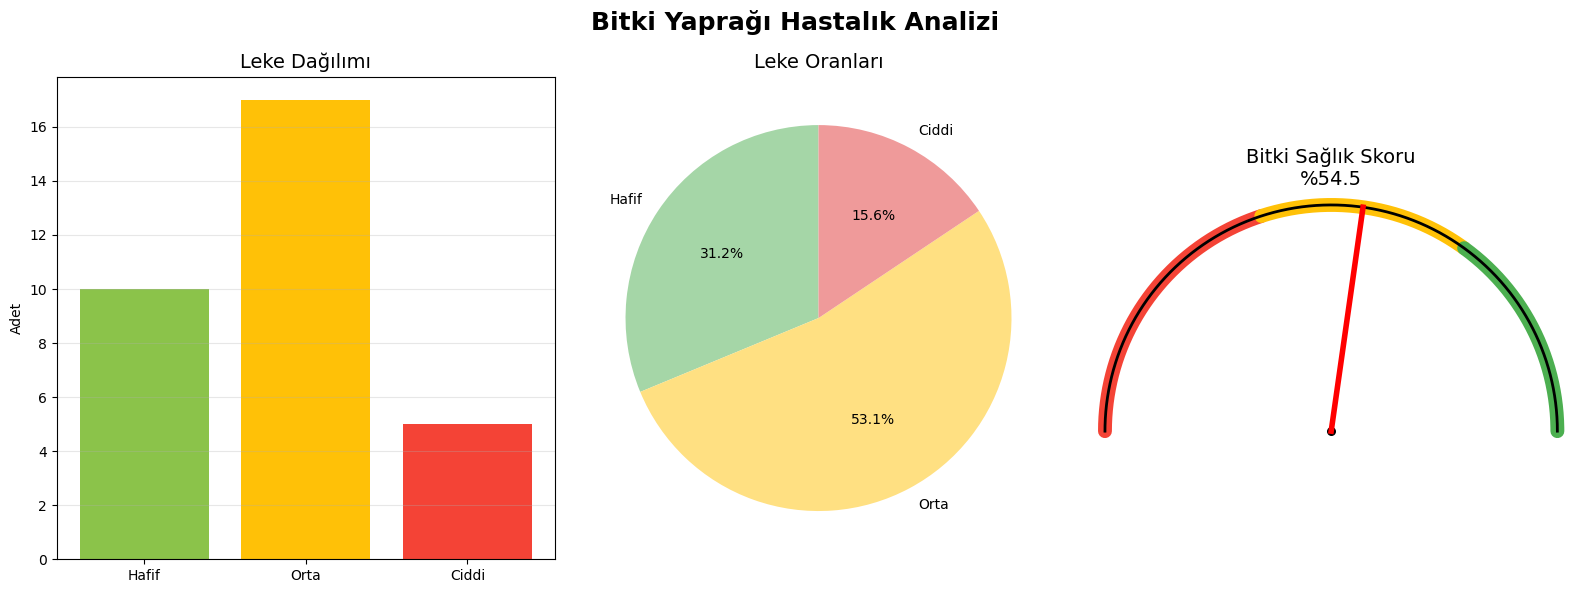

In [29]:
# Dashboard (Bar + Pie + RENKLİ Gauge)
# En sonda sonuçları grafiklerle tek ekranda özetleyip sunumu görsel hale getirdim

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(16, 6))
fig.suptitle("Bitki Yaprağı Hastalık Analizi", fontsize=18, fontweight="bold")

# Çubuk Grafik

ax1 = fig.add_subplot(1, 3, 1)
ax1.bar(["Hafif", "Orta", "Ciddi"], [hafif, orta, ciddi],
        color=["#8BC34A", "#FFC107", "#F44336"])
ax1.set_title("Leke Dağılımı", fontsize=14)
ax1.set_ylabel("Adet")
ax1.grid(axis="y", alpha=0.3)

# Pasta Grafik

ax2 = fig.add_subplot(1, 3, 2)
toplam = hafif + orta + ciddi
oranlar = [0, 0, 0] if toplam == 0 else [hafif/toplam*100, orta/toplam*100, ciddi/toplam*100]

ax2.pie(
    oranlar,
    labels=["Hafif", "Orta", "Ciddi"],
    autopct="%1.1f%%",
    colors=["#A5D6A7", "#FFE082", "#EF9A9A"],
    startangle=90
)
ax2.set_title("Leke Oranları", fontsize=14)

# RENKLİ Gauge (0–100)
ax3 = fig.add_subplot(1, 3, 3)

score = float(max(0, min(100, saglik_skoru)))

# Eşikler: 0-40 kırmızı, 40-70 sarı, 70-100 yeşil
bounds = [0, 40, 70, 100]

def score_to_angle(s):
    return np.pi * (1 - s / 100.0)

# Renkli yayların çizimi
colors = ["#F44336", "#FFC107", "#4CAF50"]  # kırmızı, sarı, yeşil
lw = 10

for i in range(3):
    s1, s2 = bounds[i], bounds[i + 1]
    a1, a2 = score_to_angle(s1), score_to_angle(s2)
    ang = np.linspace(a1, a2, 200)
    ax3.plot(np.cos(ang), np.sin(ang), color=colors[i], linewidth=lw, solid_capstyle="round")

# İnce siyah çerçeve
ang_outline = np.linspace(0, np.pi, 400)
ax3.plot(np.cos(ang_outline), np.sin(ang_outline), color="black", linewidth=2)

# İğne
angle = score_to_angle(score)
needle_x = np.cos(angle)
needle_y = np.sin(angle)
ax3.plot([0, needle_x], [0, needle_y], color="red", linewidth=4)
ax3.scatter(0, 0, color="black", s=30)

# Başlık
ax3.set_title(f"Bitki Sağlık Skoru\n%{score:.1f}", fontsize=14)
ax3.set_aspect("equal")
ax3.axis("off")

plt.tight_layout()
plt.show()
